In [88]:
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import numpy as np
# from prophet import Prophet
# from prophet.diagnostics import cross_validation, performance_metrics
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

In [89]:
import pandas as pd

# Load the first DataFrame
df1 = pd.read_pickle('df_4_files_combined_no_outliers_for_AR.pkl')
df1.index = pd.to_datetime(df1.index)
df1 = df1.asfreq('D')

# Load the second DataFrame
df2 = pd.read_pickle('df_file_combined_actual_no_outliers_for_AR.PKL')
df2.index = pd.to_datetime(df2.index)
df2 = df2.asfreq('D')

# Remove overlap (keep only rows in df2 that are not in df1)
df2_unique = df2[~df2.index.isin(df1.index)]

# Merge the DataFrames
merged_df = pd.concat([df1, df2_unique]).sort_index()

# Optional: save merged DataFrame
merged_df.to_pickle('merged_df_no_overlap.pkl')

print("Merged DataFrame shape:", merged_df.shape)


Merged DataFrame shape: (1304, 17)


In [90]:
# Remove rows with NaN values from merged_df
print("Before removing NaN values:")
print(f"merged_df shape: {merged_df.shape}")
print(f"NaN count per column:\n{merged_df.isnull().sum()}")

# Remove rows with any NaN values
merged_df = merged_df.dropna()

print("\nAfter removing NaN values:")
print(f"merged_df shape: {merged_df.shape}")
print(f"NaN count per column:\n{merged_df.isnull().sum()}")


Before removing NaN values:
merged_df shape: (1304, 17)
NaN count per column:
Total Room Inventory    9
Rooms Sold              9
Arrival Rooms           9
Compliment Rooms        9
House Use               9
Individual Confirm      9
Occupancy %             9
Room Revenue            9
ARR                     9
Departure Rooms         9
OOO Rooms               9
Pax                     9
snapshot_date           9
arrival_date            9
actual_or_forecast      9
Day                     9
revenue_diff            9
dtype: int64

After removing NaN values:
merged_df shape: (1295, 17)
NaN count per column:
Total Room Inventory    0
Rooms Sold              0
Arrival Rooms           0
Compliment Rooms        0
House Use               0
Individual Confirm      0
Occupancy %             0
Room Revenue            0
ARR                     0
Departure Rooms         0
OOO Rooms               0
Pax                     0
snapshot_date           0
arrival_date            0
actual_or_forecast      0

In [91]:
merged_df.head()

,Total Room Inventory,Rooms Sold,Arrival Rooms,Compliment Rooms,House Use,Individual Confirm,Occupancy %,Room Revenue,ARR,Departure Rooms,OOO Rooms,Pax,snapshot_date,arrival_date,actual_or_forecast,Day,revenue_diff
Date,,,,,,,,,,,,,,,,,
2021-09-02,116.0,113.0,34.0,1.0,5.0,113.0,92.2414,620455.0,5490.7527,32.0,16.0,170.0,2021-09-02,2021-09-02,actual,Thursday,2620.0
2021-09-03,118.0,116.0,39.0,0.0,4.0,116.0,94.9153,633071.0,5457.5165,35.0,14.0,169.0,2021-09-03,2021-09-03,actual,Friday,12616.0
2021-09-04,118.0,116.0,36.0,0.0,4.0,116.0,94.9153,682949.0,5887.4918,36.0,14.0,182.0,2021-09-04,2021-09-04,actual,Saturday,49878.0
2021-09-05,119.0,114.0,36.0,0.0,1.0,114.0,94.9580,664046.0,5824.9731,38.0,13.0,182.0,2021-09-05,2021-09-05,actual,Sunday,-18903.0
2021-09-06,119.0,118.0,41.0,0.0,4.0,118.0,95.7983,682494.0,5783.8554,37.0,13.0,181.0,2021-09-06,2021-09-06,actual,Monday,18448.0


In [92]:
# Create subsets without modifying merged_df
df7 = merged_df.head(7).copy()
df30 = merged_df.head(30).copy()
df90 = merged_df.head(90).copy()
df180 = merged_df.head(180).copy()
df365 = merged_df.head(365).copy()

# Verify the shapes
# print("df7 shape:", df7.shape)
print("df30 shape:", df30.shape)
print("df90 shape:", df90.shape)
print("df180 shape:", df180.shape)
print("df365 shape:", df365.shape)

# Display date ranges for each subset
print("\nDate ranges:")
# print(f"df7: {df7.index.min()} to {df7.index.max()}")
print(f"df30: {df30.index.min()} to {df30.index.max()}")
print(f"df90: {df90.index.min()} to {df90.index.max()}")
print(f"df180: {df180.index.min()} to {df180.index.max()}")
print(f"df365: {df365.index.min()} to {df365.index.max()}")

df30 shape: (30, 17)
df90 shape: (90, 17)
df180 shape: (180, 17)
df365 shape: (365, 17)

Date ranges:
df30: 2021-09-02 00:00:00 to 2021-10-01 00:00:00
df90: 2021-09-02 00:00:00 to 2021-11-30 00:00:00
df180: 2021-09-02 00:00:00 to 2022-02-28 00:00:00
df365: 2021-09-02 00:00:00 to 2022-09-01 00:00:00


In [93]:
# ----------- Data Preparation -----------

def prepare_prophet_data(df, target_col='Room Revenue', exogenous_cols=None):
    prophet_df = pd.DataFrame({'ds': df.index, 'y': df[target_col]})
    
    # Add exogenous regressors
    if exogenous_cols:
        for col in exogenous_cols:
            if col in df.columns:
                prophet_df[col] = df[col]
    
    # Day of week (one-hot)
    for i in range(7):
        prophet_df[f'day_{i}'] = (prophet_df['ds'].dt.dayofweek == i).astype(int)
    
    # Weekend flag
    prophet_df['is_weekend'] = prophet_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)
    
    # Month and quarter
    prophet_df['month'] = prophet_df['ds'].dt.month
    prophet_df['quarter'] = prophet_df['ds'].dt.quarter
    # prophet_df['day_of_year'] = prophet_df['ds'].dt.dayofyear

    
    # IN holidays
    us_holidays = holidays.IN()
    prophet_df['is_holiday'] = (prophet_df['ds'].dt.date.apply(lambda x: x in us_holidays)).astype(int)
    
    # Rolling stats on target (7 and 14 days)
    if not pd.isna(df[target_col]).all():
        for window in [7,14]:
            prophet_df[f'rolling_mean_{window}d'] = df[target_col].rolling(window=window).mean().values
            prophet_df[f'rolling_std_{window}d'] = df[target_col].rolling(window=window).std().values
    
    
    prophet_df.fillna(method='bfill', inplace=True)
    prophet_df.fillna(method='ffill', inplace=True)

    return prophet_df

WARNING - (py.warnings._showwarnmsg) - C:\Users\jnami\AppData\Local\Temp\ipykernel_148176\2163012604.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df.fillna(method='bfill', inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\jnami\AppData\Local\Temp\ipykernel_148176\2163012604.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df.fillna(method='ffill', inplace=True)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping 

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 225/225 [00:02<00:00, 81.01it/s]


Training: |          | 0/? [00:42<?, ?it/s, v_num=126, train_loss=0.011, reg_loss=0.000, MAE=1e+5, RMSE=1.33e+5, Loss=0.011, RegLoss=0.000]     

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.27it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.12it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\plot_forecast_matplotlib.py:84: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



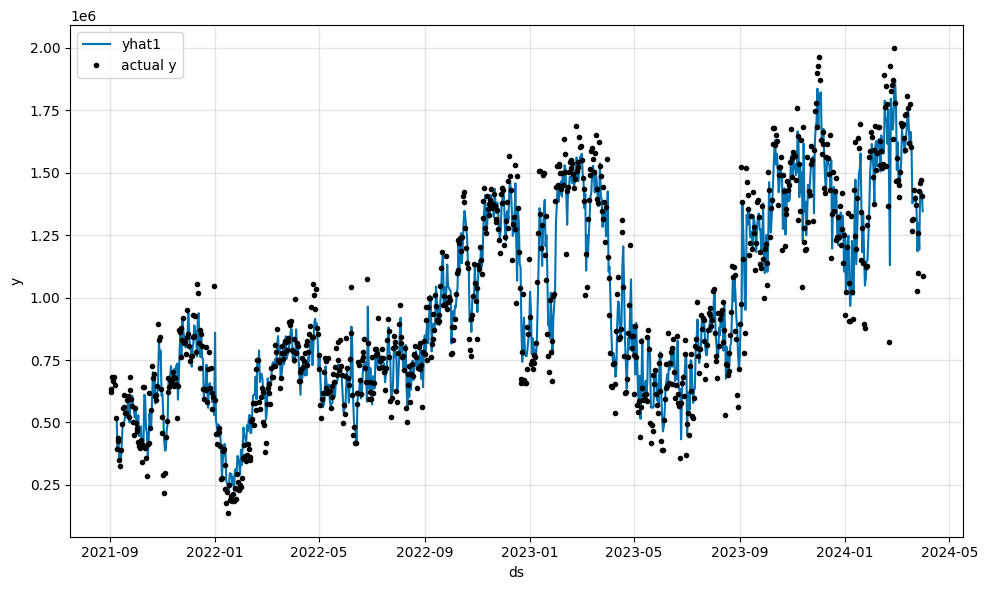

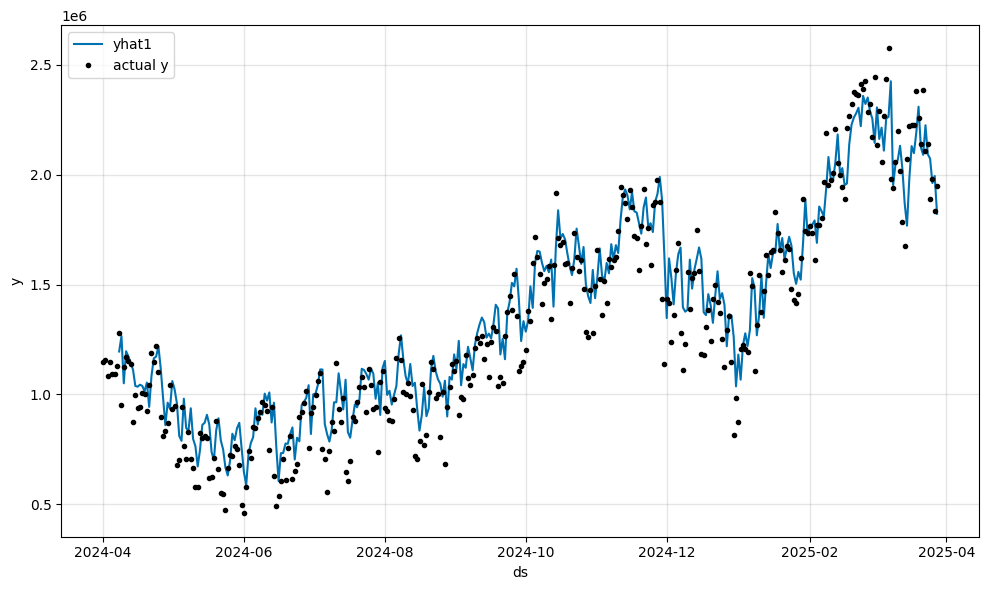

In [94]:
exog_cols = ['Arrival Rooms',  'Compliment Rooms', 'House Use', 'Individual Confirm', 'ARR', 'Departure Rooms']

prophet_df = prepare_prophet_data(
    merged_df,
    target_col='Room Revenue',
    exogenous_cols=exog_cols  # or pass your extra regressors
)
prophet_df = prophet_df[['ds', 'y']]

from neuralprophet import NeuralProphet, set_log_level
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

set_log_level("ERROR")
# -------------------------
# Train-test split (70/30 chronological)
# -------------------------
prophet_df.index = pd.to_datetime(prophet_df.index)

# Split based on date
train_df = prophet_df[prophet_df.index < '2024-04-01']
test_df  = prophet_df[prophet_df.index >= '2024-04-01']

# -------------------------
# Define NeuralProphet with exogenous regressors
# -------------------------
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=7,
)

# m = m.add_country_holidays(country_name='IN')

m.set_plotting_backend("matplotlib")  # Use matplotlib due to #1235
metrics = m.fit(train_df)
forecast = m.predict(test_df)
m.plot(m.predict(train_df))
m.plot(forecast)

In [95]:
from sklearn.metrics import mean_squared_error
import numpy as np

# -------------------------
# After forecast = m.predict(test_df)
# -------------------------

# Merge actuals and predictions for comparison
results = test_df.copy()
results = results.merge(forecast[['ds', 'yhat1']], on='ds', how='left')

# Remove any rows with NaN values in the merged results
print(f"Before removing NaN: {results.shape}")
print(f"NaN count in yhat1: {results['yhat1'].isnull().sum()}")

results = results.dropna()

print(f"After removing NaN: {results.shape}")

# Check if we have data left after removing NaN
if len(results) > 0:
    # Compute MSE and RMSE
    mse = mean_squared_error(results['y'], results['yhat1'])
    rmse = np.sqrt(mse)
    
    print(f"Test MSE: {mse:.2f}")
    print(f"Test RMSE: {rmse:.2f}")
else:
    print("No matching dates between test data and forecast. Check your data alignment.")

Before removing NaN: (355, 3)
NaN count in yhat1: 7
After removing NaN: (348, 3)
Test MSE: 24108814501.47
Test RMSE: 155270.13


WARNING - (py.warnings._showwarnmsg) - C:\Users\jnami\AppData\Local\Temp\ipykernel_148176\2163012604.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df.fillna(method='bfill', inplace=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\jnami\AppData\Local\Temp\ipykernel_148176\2163012604.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df.fillna(method='ffill', inplace=True)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping 

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 200/200 [00:02<00:00, 73.01it/s]


Training: |          | 0/? [00:11<?, ?it/s, v_num=127, train_loss=0.00393, reg_loss=0.000, MAE=4.610, RMSE=6.540, Loss=0.00393, RegLoss=0.000]  

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.58it/s]


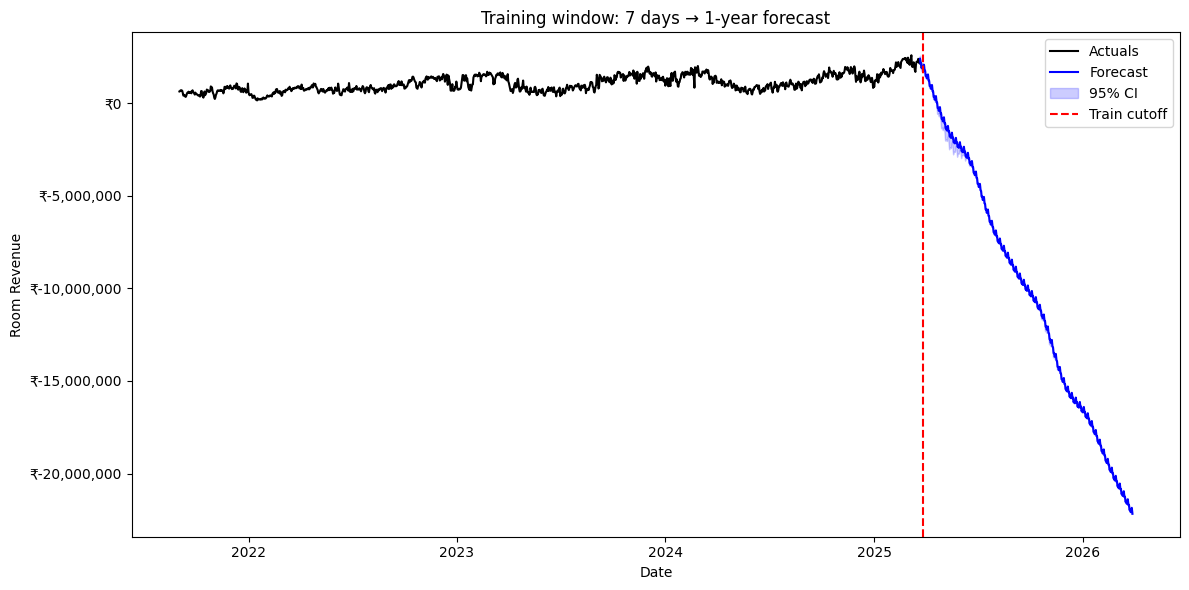

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: 

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 202/202 [00:02<00:00, 82.22it/s]


Training: |          | 0/? [00:22<?, ?it/s, v_num=128, train_loss=0.0491, reg_loss=0.000, MAE=1.2e+5, RMSE=1.56e+5, Loss=0.0496, RegLoss=0.000] 

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


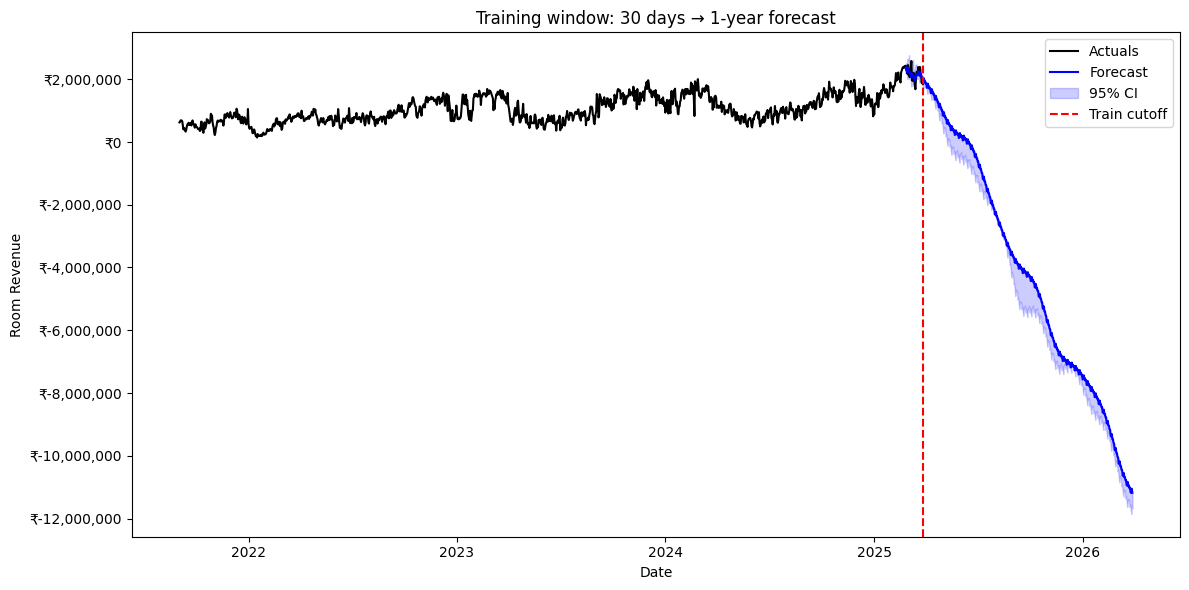

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: 

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 206/206 [00:02<00:00, 80.19it/s]


Training: |          | 0/? [00:36<?, ?it/s, v_num=129, train_loss=0.0149, reg_loss=0.000, MAE=1.29e+5, RMSE=1.59e+5, Loss=0.0162, RegLoss=0.000]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.05it/s]


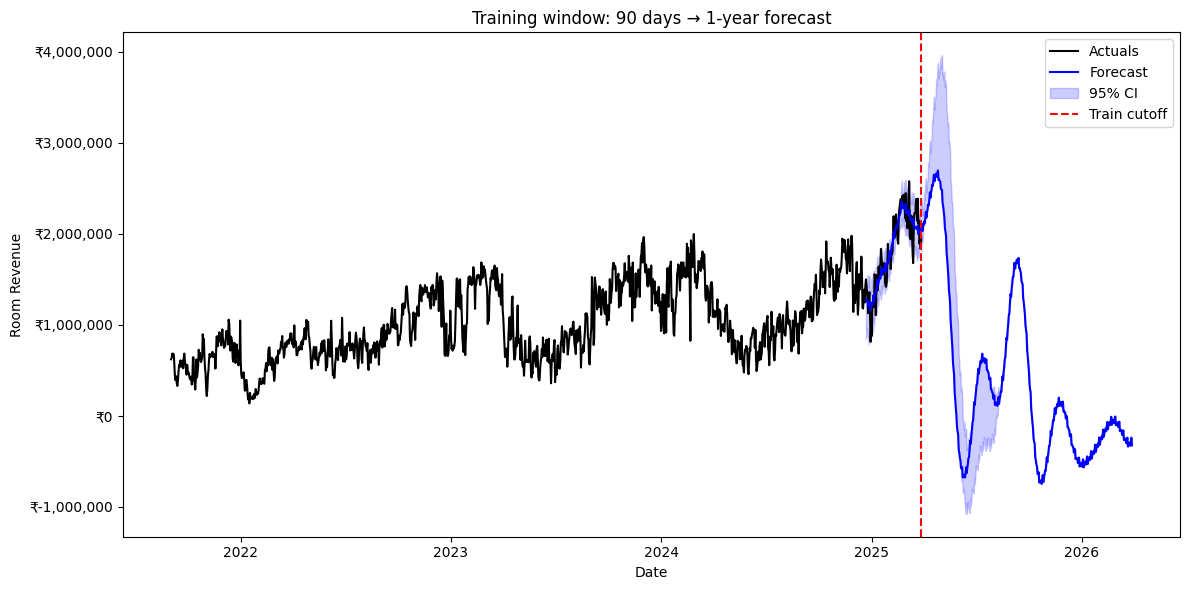

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: 

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 211/211 [00:02<00:00, 81.90it/s]


Training: |          | 0/? [00:30<?, ?it/s, v_num=130, train_loss=0.0184, reg_loss=0.000, MAE=1.46e+5, RMSE=1.72e+5, Loss=0.0183, RegLoss=0.000]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.12it/s]


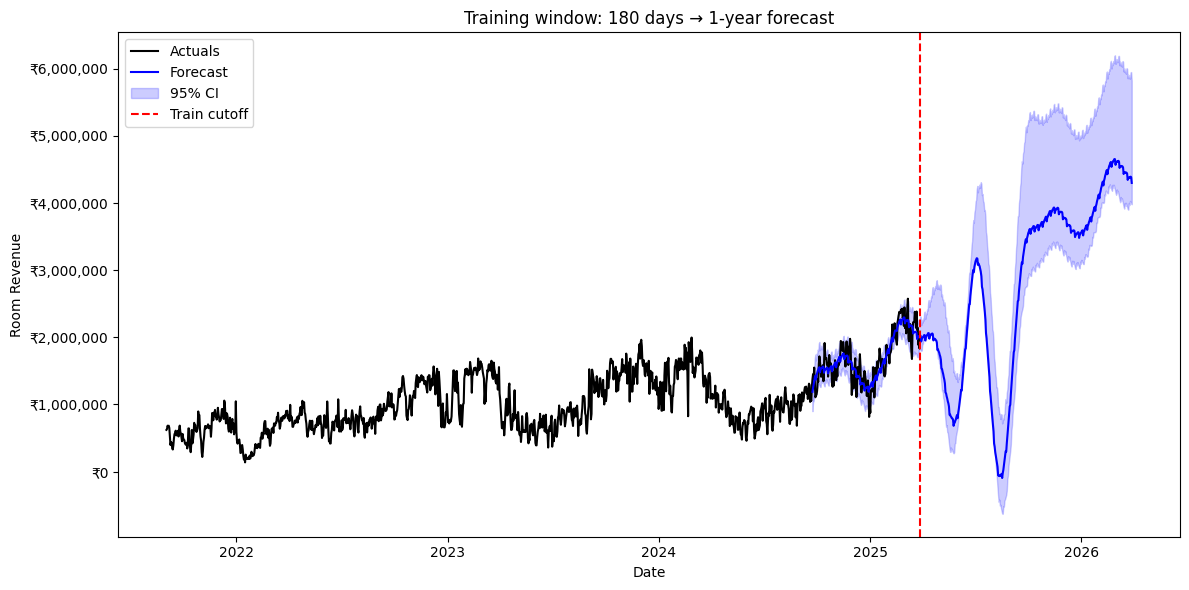

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: 

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 216/216 [00:02<00:00, 80.28it/s]


Training: |          | 0/? [01:02<?, ?it/s, v_num=131, train_loss=0.0128, reg_loss=0.000, MAE=1.29e+5, RMSE=1.55e+5, Loss=0.0128, RegLoss=0.000]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.96it/s]


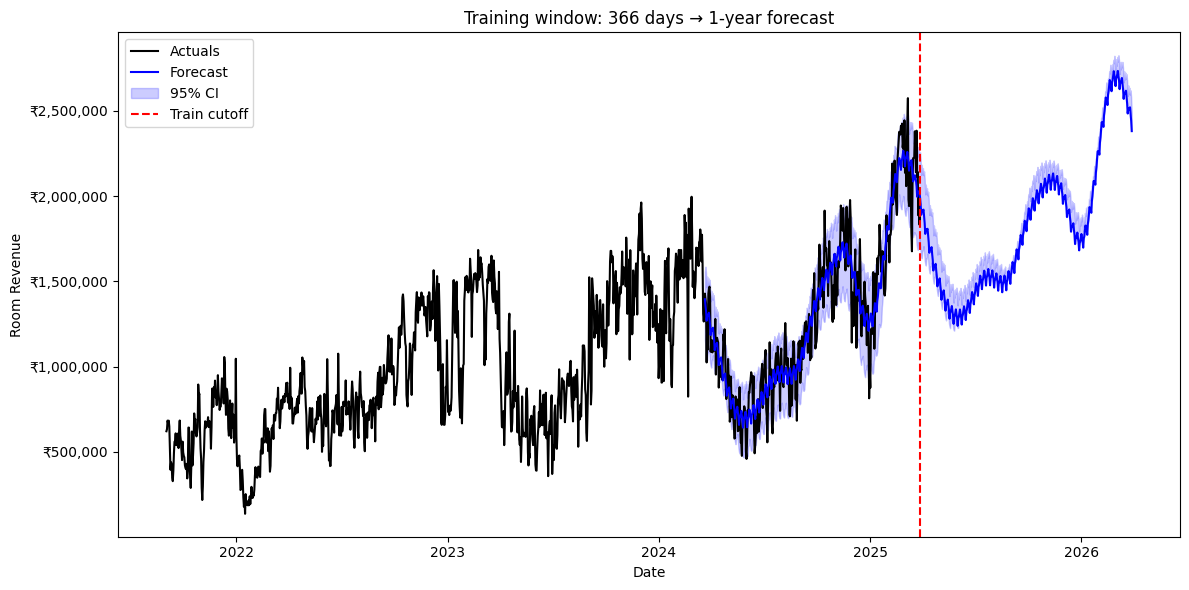

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: 

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr: 100%|██████████| 224/224 [00:04<00:00, 49.59it/s]


Training: |          | 0/? [01:03<?, ?it/s, v_num=132, train_loss=0.0194, reg_loss=0.000, MAE=1.43e+5, RMSE=1.82e+5, Loss=0.0194, RegLoss=0.000]

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\testing\lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARN


Epoch 160: 100%|██████████| 160/160 [01:09<00:00,  2.30it/s]   


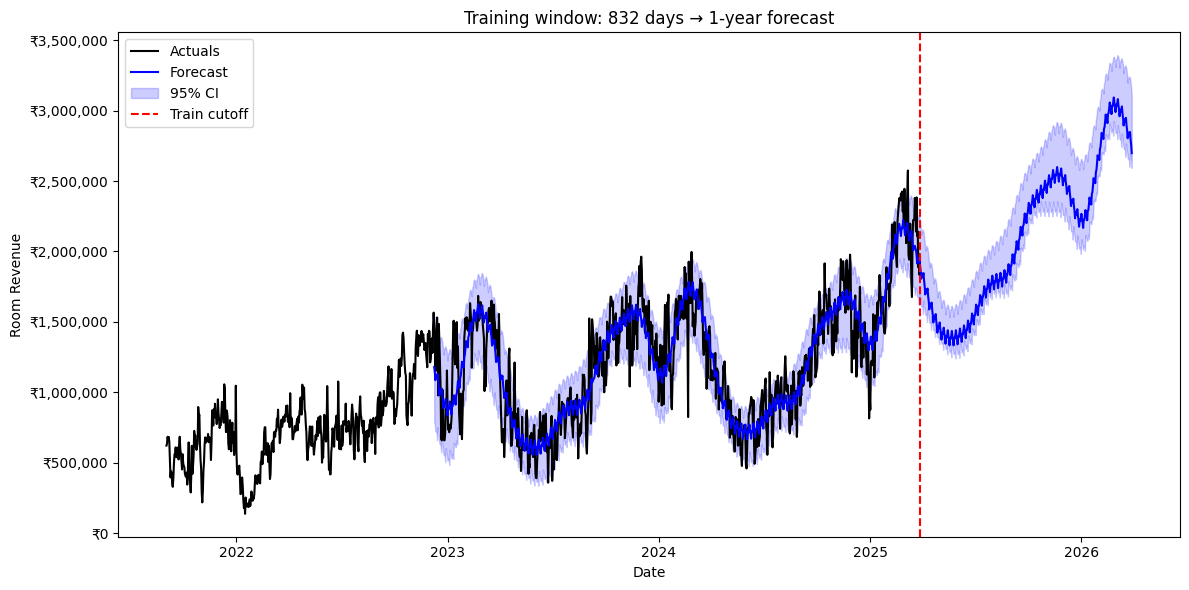

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

def train_and_forecast(train_df, full_df, horizon=365, name=""):
    """
    Train NeuralProphet on train_df and forecast 'horizon' days.
    Plot forecast + actuals from full_df with currency-style y-axis.
    """
    # Define model
    m = NeuralProphet(
        n_changepoints=10,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,  # daily might overfit small windows
        n_forecasts=3,
        quantiles=[0.025, 0.5, 0.975]  # 95% CI
    )
    m.set_plotting_backend("matplotlib")
    
    # Train
    metrics = m.fit(train_df, freq="D", progress="bar")
    
    # Make future dataframe
    future = m.make_future_dataframe(train_df, periods=horizon, n_historic_predictions=True)
    forecast = m.predict(future)
    
    # Plot forecast vs actual
    plt.figure(figsize=(12,6))
    plt.plot(full_df['ds'], full_df['y'], 'k-', label="Actuals")
    plt.plot(forecast['ds'], forecast['yhat1'], 'b-', label="Forecast")
    plt.fill_between(
        forecast['ds'], 
        forecast['yhat1 2.5%'], 
        forecast['yhat1 97.5%'], 
        color='blue', alpha=0.2, label="95% CI"
    )
    plt.axvline(train_df['ds'].iloc[-1], color="red", linestyle="--", label="Train cutoff")
    
    # 👇 Format y-axis as currency with commas
    plt.gca().yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, p: f"₹{x:,.0f}")
    )
    
    plt.title(f"Training window: {name} days → 1-year forecast")
    plt.xlabel("Date")
    plt.ylabel("Room Revenue")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return forecast


# -------------------------
# Main pipeline
# -------------------------

# Assume merged_df already indexed with datetime
prophet_df = prepare_prophet_data(
    merged_df,
    target_col='Room Revenue',
    exogenous_cols=None  # or pass exogenous regressors
)

# Ensure correct format
prophet_df = prophet_df[['ds','y']]

# Train on different windows
windows = [7, 30, 90, 180, 366, 832]
forecasts = {}

for w in windows:
    df_train = prophet_df.tail(w)
    forecasts[w] = train_and_forecast(df_train, prophet_df, horizon=366, name=str(w))